# Exploratory Data Analysis 

-------------------------------------

by Natalia López Gallego

To create a clean dataset and build a model to predict if a product is **new or used** based on the `condition` column, we will perform an Exploratory Data Analysis first.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import jsonlines
import json

from pandas import json_normalize 

In [2]:
df = pd.read_json('../MLA_100k.jsonlines', lines=True)

In [3]:
# Detect nested columns
cols_dict = [col for col in df.columns if df[col].apply(lambda x: isinstance(x, dict)).any()]
cols_list = [col for col in df.columns if df[col].apply(lambda x: isinstance(x, list)).any()]

print("Dict type columns (nested):")
print(cols_dict)

print("\nList type columns:")
print(cols_list)


Dict type columns (nested):
['seller_address', 'seller_contact', 'shipping', 'location', 'geolocation']

List type columns:
['sub_status', 'deal_ids', 'non_mercado_pago_payment_methods', 'variations', 'attributes', 'tags', 'coverage_areas', 'descriptions', 'pictures']


In [ ]:
def normalize_json(data):
    """
    Normalize a complex MercadoLibre item JSON into a flat dictionary.

    Args:
        data (dict): JSON dictionary representing a MercadoLibre item.

    Returns:
        dict: Normalized flat dictionary with selected fields.
    """

    # Helper functions
    def get_nested(d, keys, default=None):
        """Safe nested get from dictionary."""
        for key in keys:
            if isinstance(d, dict):
                d = d.get(key, {})
            else:
                return default
        return d if d else default

    def join_list(data_list, key):
        """Join values from a list of dicts by a key."""
        return ", ".join([str(d.get(key, "")) for d in data_list if isinstance(d, dict) and d.get(key)])

    def flatten_variations(variations):
        """Summarize variations (e.g., sizes, total stock)."""
        result = []
        for var in variations:
            attr = {a.get("name"): a.get("value_name") for a in var.get("attribute_combinations", [])}
            size = attr.get("Talle", "")
            color = attr.get("Color Primario", "")
            qty = var.get("available_quantity", 0)
            result.append(f"{color}-{size}: {qty}")
        return "; ".join(result)

    def flatten_attributes(attributes):
        """Flatten list of attribute dicts into key: value pairs."""
        return {f"attr_{a.get('id', '').lower()}": a.get("value_name", "") for a in attributes if isinstance(a, dict)}

    def flatten_coverage_areas(areas):
        """Summarize coverage area info."""
        return "; ".join([f"{a.get('shipping_method_id')}-{a.get('description')}" for a in areas if isinstance(a, dict)])

    normalized = {
        "id": data.get("id"),
        "title": data.get("title"),
        "condition": data.get("condition"),
        "status": data.get("status"),
        "category_id": data.get("category_id"),
        "price": data.get("price"),
        "base_price": data.get("base_price"),
        "original_price": data.get("original_price"),
        "currency_id": data.get("currency_id"),
        "warranty": data.get("warranty"),
        "buying_mode": data.get("buying_mode"),
        "listing_type_id": data.get("listing_type_id"),
        "date_created": data.get("date_created"),
        "last_updated": data.get("last_updated"),
        "start_time": data.get("start_time"),
        "stop_time": data.get("stop_time"),
        "initial_quantity": data.get("initial_quantity"),
        "available_quantity": data.get("available_quantity"),
        "sold_quantity": data.get("sold_quantity"),
        "accepts_mercadopago": data.get("accepts_mercadopago"),
        "automatic_relist": data.get("automatic_relist"),
        "international_delivery_mode": data.get("international_delivery_mode"),
        "seller_id": data.get("seller_id"),
        "official_store_id": data.get("official_store_id"),
        "subtitle": data.get("subtitle"),
        "listing_source": data.get("listing_source"),
        "catalog_product_id": data.get("catalog_product_id"),
        "site_id": data.get("site_id"),
        "secure_thumbnail": data.get("secure_thumbnail"),
        "thumbnail": data.get("thumbnail"),
        "permalink": data.get("permalink"),
        "parent_item_id": data.get("parent_item_id"),

        # Location & geolocation
        "geo_latitude": get_nested(data, ["geolocation", "latitude"]),
        "geo_longitude": get_nested(data, ["geolocation", "longitude"]),
        "location_address_line": get_nested(data, ["location", "address_line"]),
        "location_zip_code": get_nested(data, ["location", "zip_code"]),

        # Shipping
        "shipping_mode": get_nested(data, ["shipping", "mode"]),
        "local_pick_up": get_nested(data, ["shipping", "local_pick_up"]),
        "free_shipping": get_nested(data, ["shipping", "free_shipping"]),

        # Seller address
        "address_id": get_nested(data, ["seller_address", "id"]),
        "address_comment": get_nested(data, ["seller_address", "comment"]),
        "address_line": get_nested(data, ["seller_address", "address_line"]),
        "zip_code": get_nested(data, ["seller_address", "zip_code"]),
        "latitude": get_nested(data, ["seller_address", "latitude"]),
        "longitude": get_nested(data, ["seller_address", "longitude"]),
        "address_country_id": get_nested(data, ["seller_address", "country", "id"]),
        "address_country_name": get_nested(data, ["seller_address", "country", "name"]),
        "address_state_id": get_nested(data, ["seller_address", "state", "id"]),
        "address_state_name": get_nested(data, ["seller_address", "state", "name"]),
        "address_city_id": get_nested(data, ["seller_address", "city", "id"]),
        "address_city_name": get_nested(data, ["seller_address", "city", "name"]),
        "neighborhood_id": get_nested(data, ["seller_address", "search_location", "neighborhood", "id"]),
        "neighborhood_name": get_nested(data, ["seller_address", "search_location", "neighborhood", "name"]),
        "search_city_id": get_nested(data, ["seller_address", "search_location", "city", "id"]),
        "search_city_name": get_nested(data, ["seller_address", "search_location", "city", "name"]),
        "search_state_id": get_nested(data, ["seller_address", "search_location", "state", "id"]),
        "search_state_name": get_nested(data, ["seller_address", "search_location", "state", "name"]),

        # Descriptions and tags
        "description_id": data.get("descriptions", [{}])[0].get("id") if data.get("descriptions") else None,
        "tags": ", ".join(data.get("tags", [])),

        # Pictures
        "pictures": join_list(data.get("pictures", []), "secure_url"),
        "pictures_info": str([
            {
                "id": pic.get("id"),
                "url": pic.get("url"),
                "secure_url": pic.get("secure_url"),
                "size": pic.get("size"),
                "max_size": pic.get("max_size"),
                "quality": pic.get("quality")
            }
            for pic in data.get("pictures", [])
        ]),

        # Payment methods
        "non_mercado_pago_methods": join_list(data.get("non_mercado_pago_payment_methods", []), "description"),

        # Variations
        "variations_summary": flatten_variations(data.get("variations", [])),

        # Coverage areas (if exists)
        "coverage_areas_summary": flatten_coverage_areas(data.get("coverage_areas", [])) if "coverage_areas" in data else None,

        # Substatus
        "sub_status": ", ".join(data.get("sub_status", [])),
    }

    #  Add flattened attributes as individual fields (e.g., attr_brand, attr_model)
    normalized.update(flatten_attributes(data.get("attributes", [])))

    return normalized


In [5]:
# Read jsonlines file, normalize each line and save them
with jsonlines.open('../MLA_100k.jsonlines', mode='r') as reader, jsonlines.open('output_normalized.jsonl', mode='w') as writer:
    for obj in reader:
        normalized_data = normalize_json(obj)
        writer.write(normalized_data)

In [47]:
# Read normalized JSON Lines file
data = []
with jsonlines.open("output_normalized.jsonl", mode="r") as reader:
    for obj in reader:
        data.append(obj)

# Converto to DataFrame
df = pd.DataFrame(data)

In [7]:
df.head()

,id,title,condition,status,category_id,price,base_price,original_price,currency_id,warranty,...,attr_mla1943-marc,attr_mla1943-modl,attr_mla87164-vers,attr_mla6609-vers,attr_mla6631-vers,attr_mla6600-modl,attr_mla29471-vers,attr_mla6632-vers,attr_mla6637-vers,attr_mla29423-vers
0,MLA578052519,Auriculares Samsung Originales Manos Libres Ca...,new,active,MLA126406,80.0,80.0,NaN,ARS,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,MLA581565358,Cuchillo Daga Acero Carbón Casco Yelmo Solinge...,used,active,MLA10267,2650.0,2650.0,NaN,ARS,NUESTRA REPUTACION,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,MLA578780872,"Antigua Revista Billiken, N° 1826, Año 1954",used,active,MLA1227,60.0,60.0,NaN,ARS,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,MLA581877385,Alarma Guardtex Gx412 Seguridad Para El Automo...,new,active,MLA86345,580.0,580.0,NaN,ARS,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,MLA576112692,Serenata - Jennifer Blake,used,active,MLA41287,30.0,30.0,NaN,ARS,MI REPUTACION.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 1133 entries, id to attr_mla29423-vers
dtypes: bool(2), float64(10), int64(4), object(1117)
memory usage: 863.1+ MB


Our DataFrame is comprised by 100000 entries and  columns with an `object` data type.

In [9]:
df.describe(include='all') 

,id,title,condition,status,category_id,price,base_price,original_price,currency_id,warranty,...,attr_mla1943-marc,attr_mla1943-modl,attr_mla87164-vers,attr_mla6609-vers,attr_mla6631-vers,attr_mla6600-modl,attr_mla29471-vers,attr_mla6632-vers,attr_mla6637-vers,attr_mla29423-vers
count,100000,100000,100000,100000,100000,1.000000e+05,1.000000e+05,143.000000,100000,39104,...,2,2,1,1,1,1,1,1,1,1
unique,100000,98823,2,4,10907,NaN,NaN,NaN,2,10264,...,1,2,1,1,1,1,1,1,1,1
top,MLA581762902,50 Suspensores Para Short De Baño Tela Calada,new,active,MLA1227,NaN,NaN,NaN,ARS,Sí,...,Otras marcas,"4,50",350 E Elegance,GTD,,wiilys,hunday inovation,SR,,Clase C 200 Kompressor MT Avantgarde
freq,1,78,53758,95675,4593,NaN,NaN,NaN,99433,5682,...,2,1,1,1,1,1,1,1,1,1
mean,NaN,NaN,NaN,NaN,NaN,5.252433e+04,5.252423e+04,1593.341958,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,8.623127e+06,8.623127e+06,2245.798072,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,8.400000e-01,8.400000e-01,120.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,9.000000e+01,9.000000e+01,449.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,2.500000e+02,2.500000e+02,858.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,8.000000e+02,8.000000e+02,1500.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Some columns could be disregarded, but several factors should be considered, such as redundancy, low variability, or limited usefulness for analysis. Here are some observations to help us with this:

1. **Redundancy**: Some columns appear to contain duplicate information. For example:
   - `seller_address_country_name` and `seller_address_country_id` provide the same data in different formats.
   - `seller_address_state_name` and `seller_address_state_id`, as well as city and neighborhood.

2. **Low-information columns**: If a column does not add value to the analysis, it may be unnecessary. For instance:
   - `seller_address_comment`: If these comments are unstructured and not useful for analysis, they might not be needed.
   - `sub_status`: Its relevance depends on the context of your study.

3. **Columns with missing values**: The column `warranty` has many missing values (only 39,104 out of 100,000 records, more than a thrid part). If warranty information is not crucial, it could be disregarded.

## **Data Transformation and Cleaning**

To prepare the data for our model we will follow these steps:

### 1. **Target variable encoding**

* `condition` will be our target variable.
* Encode it as:

  * `"new"` → 1
  * `"used"` → 0


In [48]:
# Applying the mapping
df['condition'] = df['condition'].map({'new': 1, 'used': 0})

In [49]:
# Verifying the mapping
condition_unique = df['condition'].unique()
print(condition_unique)

[1 0]



### 2. **Drop high-cardinality or redundant columns**

The following columns are either:

* IDs with no predictive power,
* exact duplicates under different names.
* or long text not relevant for classification.

In [50]:
def drop_id_columns(df):
    """
    Drops all columns from a DataFrame whose name contains 'id' (case-insensitive).

    Args:
        df (pd.DataFrame): Input DataFrame.

    Returns:
        pd.DataFrame: DataFrame without 'id'-containing columns.
    """
    return df.loc[:, ~df.columns.str.contains('id', case=False)]

# Drop columns with 'id' in the name
df_cleaned = drop_id_columns(df)

`secure_thumbnail`, `thumbnail`, and `permalink` are URLs, which are not useful for classification.

In [ ]:
df_cleaned.drop(["secure_thumbnail", "thumbnail", "permalink"], axis=1, inplace=True)

### 3. **Handle missing values**


 Our approach is to **drop columns that contain more than 33% null values**. Below are the key reasons for this decision:

**Preserving Data Quality**
Columns with excessive missing values can reduce the reliability of insights drawn from the data. If more than one-third of a column’s values are absent, the available data may not be representative or useful.

**Reducing Bias in Analysis**
A high percentage of nulls can introduce bias, especially if the missing values are not randomly distributed. This can lead to skewed interpretations and affect predictive models.

**Simplifying Dataset Structure**
Eliminating columns with excessive null values results in a more manageable and interpretable dataset, making exploratory analysis and feature engineering more effective.

In [51]:
# Define threshold
threshold = 0.33  # 33%

# Calculate null percentage
null_percentage = df_cleaned.isnull().mean()

# Drop columns exceeding threshold
columns_to_drop = null_percentage[null_percentage > threshold].index
df_cleaned = df_cleaned.drop(columns=columns_to_drop)

print(f"Columns dropped: {list(columns_to_drop)}")

Columns dropped: ['original_price', 'warranty', 'subtitle', 'location_address_line', 'location_zip_code', 'free_shipping', 'address_comment', 'address_line', 'zip_code', 'neighborhood_name', 'attr_part_number', 'attr_gender', 'attr_season', 'attr_mla-part_number', 'attr_mla1743-horpref', 'attr_mla1744-colorext', 'attr_mla1744-direc', 'attr_mla1744-owner', 'attr_mla1744-airacon', 'attr_mla1744-alarmluc', 'attr_mla1744-aperbaul', 'attr_mla1744-asienelec', 'attr_mla1744-asrebat', 'attr_mla1744-asregula', 'attr_mla1744-blqcntdoor', 'attr_mla1744-climaut', 'attr_mla1744-compabo', 'attr_mla1744-ctrlvel', 'attr_mla1744-espelec', 'attr_mla1744-estacionam', 'attr_mla1744-faroreg', 'attr_mla1744-gps', 'attr_mla1744-sensll', 'attr_mla1744-sensluz', 'attr_mla1744-tapcuero', 'attr_mla1744-techocorr', 'attr_mla1744-limpia_lav', 'attr_mla1744-llanaleac', 'attr_mla1744-paragolpes', 'attr_mla1744-combus', 'attr_mla1744-door', 'attr_mla1744-kmts', 'attr_mla1744-marc', 'attr_mla1744-modl', 'attr_mla1744-

### Remaining nulls

In [13]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 38 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   title                        100000 non-null  object 
 1   condition                    100000 non-null  int64  
 2   status                       100000 non-null  object 
 3   price                        100000 non-null  float64
 4   base_price                   100000 non-null  float64
 5   buying_mode                  100000 non-null  object 
 6   date_created                 100000 non-null  object 
 7   last_updated                 100000 non-null  object 
 8   start_time                   100000 non-null  object 
 9   stop_time                    100000 non-null  object 
 10  initial_quantity             100000 non-null  int64  
 11  available_quantity           100000 non-null  int64  
 12  sold_quantity                100000 non-null  int64  
 13  

The columns `address_country_name`, `address_state_name`, `address_city_name`, `geo_latitude`, `geo_longitude`, `latitude`, `longitude`,`search_city_name`, `search_state_name`,and `local_pick_up` still contain nulls.


##### **Address-based location data**

   - **`address_country_name`, `address_state_name`, `address_city_name`**  represent the **actual recorded address** of an entity (likely a user, business, or location). They are mostly complete, with nearly **99,997** non-null values (except for `address_city_name`, which has one missing value). These fields are likely pulled from official data sources or user-provided information.  

   -  On the other hand, **`search_city_name`, `search_state_name`** represent the **searched or queried location** rather than an exact recorded address. These fields likely reflect user searches or inferred locations from interactions rather than official records.  

  - **`address_*` columns are more reliable** because they contain officially recorded or input data.  
  - **`search_*` columns may indicate user intent**, which can be useful for understanding trends but may not always align with actual locations.  

  So the search columns could be dropped, as well as geolocation data.


##### **Removing Highly Null Columns**
- **`local_pick_up`** has nearly **20% nulls**, which might indicate missing logistics details.  It can be dropped.


To manage missing location data, first we identify rows where `address_*` columns have null values. Then, we compare them with `search_city_name` and `search_state_name` to see if these fields provide useful information for filling gaps. If search-based location data is relevant, we impute missing values in `address_city_name` and `address_state_name` using available search data. Finally, validate the approach by checking for inconsistencies or mismatches before finalizing the cleaned dataset.


In [52]:
# Filter rows with nulls in address_* columns
missing_address = df_cleaned[
    df_cleaned["address_city_name"].isnull() | 
    df_cleaned["address_state_name"].isnull() | 
    df_cleaned["address_country_name"].isnull()
]

missing_address

,title,condition,status,price,base_price,buying_mode,date_created,last_updated,start_time,stop_time,...,address_city_name,search_city_name,search_state_name,tags,pictures,pictures_info,non_mercado_pago_methods,variations_summary,coverage_areas_summary,sub_status
38715,Drill Grinding Attachment Con Instrucciones.,0,active,400.0,400.0,buy_it_now,2015-09-09T03:34:09.000Z,2015-09-09T03:34:11.000Z,2015-09-09T03:34:09.000Z,2015-11-08T03:34:09.000Z,...,None,None,None,dragged_bids_and_visits,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,"[{'id': '531201-MLA20274882809_042015', 'url':...",,,,
61296,Compre Inhibidos Autos Prendados Chocada Volc...,0,active,22000.0,22000.0,classified,2015-10-15T00:34:24.000Z,2015-10-15T00:34:24.000Z,2015-10-15T00:34:23.000Z,2015-10-18T00:58:14.000Z,...,None,Capital Federal,Capital Federal,,https://a248.e.akamai.net/mla-s1-p.mlstatic.co...,"[{'id': '956011-MLA20451293145_102015', 'url':...",,,,
93402,"Alquilo Duplex 3 Amb,a 3 Cuadras De Playa,y A ...",0,active,600.0,600.0,classified,2014-12-13T21:15:41.000Z,2015-10-05T22:11:37.176Z,2014-12-19T21:15:41.000Z,2015-12-19T21:15:41.000Z,...,None,None,None,dragged_visits,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,"[{'id': '13606-MLA3396375290_112012', 'url': '...",,,,
97517,"Garrafa R22 Kg13,600",1,active,1850.0,1850.0,buy_it_now,2015-09-14T13:46:27.000Z,2015-09-14T13:52:39.000Z,2015-09-14T13:46:27.000Z,2015-11-13T13:46:27.000Z,...,None,None,None,dragged_bids_and_visits,https://a248.e.akamai.net/mla-s2-p.mlstatic.co...,"[{'id': '235801-MLA20408564275_092015', 'url':...",Efectivo,,,


In [58]:
# List of indices to check
indices_to_check = [38715, 93402, 97517]

# Filter DataFrame for these indices
filtered_df = df.loc[indices_to_check, ["latitude", "longitude","search_city_name", "search_state_name"]]

# Check for non-null values
non_null_check = filtered_df.notnull()

# Display results
print(non_null_check)

       latitude  longitude  search_city_name  search_state_name
38715     False      False             False              False
93402     False      False             False              False
97517     False      False             False              False


In [60]:
# Fill missing values with the most frequent value (mode)
df_cleaned["address_city_name"] = df_cleaned["address_city_name"].fillna(df_cleaned["address_city_name"].mode()[0])
df_cleaned["address_state_name"] = df_cleaned["address_state_name"].fillna(df_cleaned["address_state_name"].mode()[0])
df_cleaned["address_country_name"] = df_cleaned["address_country_name"].fillna(df_cleaned["address_country_name"].mode()[0])

Finally we are going to remove the `local_pick_up` and geolocalitation columns.

In [61]:
df_cleaned = df_cleaned.drop(columns=["geo_latitude", "geo_longitude", "latitude", "longitude", 
                      "search_city_name", "search_state_name", "local_pick_up"])

In [62]:
print(df_cleaned[["address_city_name", "address_state_name", "address_country_name"]].isnull().sum())

address_city_name       0
address_state_name      0
address_country_name    0
dtype: int64


### 4. **Transforming features**

In [68]:
# Check the number of unique values per column
unique_counts = df_cleaned.nunique()
print(unique_counts)

title                           98823
condition                           2
status                              4
price                           10331
base_price                      10330
buying_mode                         3
date_created                    87075
last_updated                    95124
start_time                      86628
stop_time                       86165
initial_quantity                  450
available_quantity                468
sold_quantity                     317
accepts_mercadopago                 2
automatic_relist                    2
international_delivery_mode         1
listing_source                      1
secure_thumbnail                97968
thumbnail                       97968
permalink                      100000
shipping_mode                       4
address_country_name                1
address_state_name                 24
address_city_name                3655
tags                                8
pictures                        98148
pictures_inf

Since title length might show a trend, we can transform it into a numerical feature.

In [70]:
df_cleaned["title_length"] = df_cleaned["title"].apply(len)

In [94]:
df["title_word_count"] = df["title"].str.split().apply(len)

Now, categorical features such as `address_city_name` and  `address_state_name` contain  thousands of unique categories, making them challenging for machine learning models. Therefore, we will use Frequency encoding which replaces each category with its corresponding count, allowing models to recognize patterns based on category prevalence.


In [71]:
df_cleaned["address_city_name_freq"] = df_cleaned["address_city_name"].map(df_cleaned["address_city_name"].value_counts())
df_cleaned.drop(["address_city_name"], axis=1, inplace=True)

We are going to perform feature engineering for the dates, converting date columns into meaningful numerical representations. We use `start_time` and `stop_time` to measure how long an item was actively listed before being removed or sold.Shorter durations might indicate high demand for new items, while longer times might suggest a used product remaining available.

In [84]:
# Convert start_time and stop_time to datetime format
df_cleaned["start_time"] = pd.to_datetime(df_cleaned["start_time"])
df_cleaned["stop_time"] = pd.to_datetime(df_cleaned["stop_time"])

# Calculate listing duration in days
df_cleaned["listing_duration"] = (df_cleaned["stop_time"] - df_cleaned["start_time"]).dt.days

# Display result
print(df_cleaned[["start_time", "stop_time", "listing_duration"]].head())

                 start_time                 stop_time  listing_duration
0 2015-09-05 20:42:53+00:00 2015-11-04 20:42:53+00:00                60
1 2015-09-26 18:08:30+00:00 2015-11-25 18:08:30+00:00                60
2 2015-09-09 23:57:07+00:00 2015-11-08 23:57:07+00:00                60
3 2015-09-28 18:47:56+00:00 2015-12-04 01:13:16+00:00                66
4 2015-08-24 22:07:20+00:00 2015-10-23 22:07:20+00:00                60


Now we use `date_created` to analyze item age, and to calculate `days_since_last_updated`. If `days_since_last_updated` is recent, it could indicate an active listing, which might suggest new stock availability.

In [88]:
df_cleaned["date_created"] = pd.to_datetime(df_cleaned["date_created"]).dt.tz_localize(None)  # Make it naive
df_cleaned["last_updated"] = pd.to_datetime(df_cleaned["last_updated"]).dt.tz_localize(None) 

In [89]:
df_cleaned["days_since_created"] = (pd.to_datetime("today") - df_cleaned["date_created"]).dt.days
df_cleaned["days_since_last_updated"] = (pd.to_datetime("today") - pd.to_datetime(df_cleaned["last_updated"])).dt.days

We also have to handle `tags`.

In [100]:
print(df_cleaned["tags"].unique())

['dragged_bids_and_visits' ''
 'good_quality_thumbnail, dragged_bids_and_visits'
 'good_quality_thumbnail' 'dragged_visits' 'dragged_visits, free_relist'
 'poor_quality_thumbnail, dragged_bids_and_visits'
 'poor_quality_thumbnail']


Each row can contain **single or multiple tags**, separated by commas. Here’s what they likely indicate:

**`dragged_bids_and_visits`** → The listing has been interacted with (users dragged it while bidding or visiting).  
**Empty String (`''`)** → Some listings might **not have any tags assigned**.  
**`good_quality_thumbnail, dragged_bids_and_visits`** → The listing has a **high-quality thumbnail**, and users have interacted with it.  
**`good_quality_thumbnail`** → The item has a **clear, well-defined thumbnail**, which can improve visibility.  
**`dragged_visits`** → The listing was interacted with by users while browsing (dragging but no bidding).  
**`dragged_visits, free_relist`** → The item had **dragged visits**, and it was relisted for free (possibly due to platform promotion).  
**`poor_quality_thumbnail, dragged_bids_and_visits`** → The item has a **low-quality thumbnail**, but users interacted with it.  
**`poor_quality_thumbnail`** → The thumbnail is **not visually appealing**, which may impact sales.  


### 5. **Columns to Drop (Not Useful for Classification)**



In [104]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 34 columns):
 #   Column                       Non-Null Count   Dtype              
---  ------                       --------------   -----              
 0   title                        100000 non-null  object             
 1   condition                    100000 non-null  int64              
 2   status                       100000 non-null  object             
 3   price                        100000 non-null  float64            
 4   base_price                   100000 non-null  float64            
 5   buying_mode                  100000 non-null  object             
 6   date_created                 100000 non-null  datetime64[ns]     
 7   last_updated                 100000 non-null  datetime64[ns]     
 8   start_time                   100000 non-null  datetime64[ns, UTC]
 9   stop_time                    100000 non-null  datetime64[ns, UTC]
 10  initial_quantity             1000

In [105]:
# Check the number of unique values per column
unique_counts = df_cleaned.nunique()
print(unique_counts)

title                          98823
condition                          2
status                             4
price                          10331
base_price                     10330
buying_mode                        3
date_created                   87075
last_updated                   95124
start_time                     86628
stop_time                      86165
initial_quantity                 450
available_quantity               468
sold_quantity                    317
accepts_mercadopago                2
automatic_relist                   2
international_delivery_mode        1
listing_source                     1
shipping_mode                      4
address_country_name               1
address_state_name                24
tags                               8
pictures                       98148
pictures_info                  98156
non_mercado_pago_methods         188
variations_summary              3194
coverage_areas_summary             1
sub_status                         4
t

To optimize our dataset for a **classification model**, we are going remove columns that are **not useful for predicting item condition (new vs. used)**. The strategy we are going to use handles variables based on their cardinality and type:

- High-cardinality categorical features: encode cautiously to prevent overfitting.
- Low/medium-cardinality categorical features: use OneHot or Label Encoding.
- Continuous/numerical features: scale or keep raw if appropriate.
- Dates: prefer to use derived features (e.g., "days_since_created") instead of raw timestamps.


The following features are the ones that are going to be used.

In [ ]:
numerical_features = [
    "price", "base_price",
    "initial_quantity", "available_quantity", "sold_quantity",
    "title_length", "address_city_name_freq",
    "year_created", "month_created",
    "days_since_created", "listing_duration", "days_since_last_updated"
]


onehot_features = [
    "status",           # 4 categories
    "buying_mode",      # 3 categories
    "shipping_mode",    # 4 categories
    "address_state_name",  # 24 categories
    "sub_status"        # 4 categories
    "tags"              # 8 categories
]
# Use OneHotEncoder (drop='first' to reduce multicollinearity)

binary_features = [
    "accepts_mercadopago", "automatic_relist"
]

We may drop `base_price` if it's highly correlated with `price`.

In [108]:
df_cleaned[['price', 'base_price']].corr()

,price,base_price
price,1.0,1.0
base_price,1.0,1.0


In [ ]:
columns_to_drop = [
    'title',                      # high cardinality text
    'pictures',                  # high cardinality, unstructured
    'pictures_info',            # high cardinality, unstructured
    'non_mercado_pago_methods',  # complex structure
    'variations_summary',        # unstructured
    'date_created',              # raw timestamp
    'last_updated',              # raw timestamp
    'start_time',                # raw timestamp
    'stop_time',                 # raw timestamp
    'international_delivery_mode',  # only one unique value
    'coverage_areas_summary',       # only one unique value
    'address_country_name',         # only one unique value
    'listing_source'               # only one unique value
    'base_price'  # dropped due to perfect correlation with price
]


df_cleaned = df_cleaned.drop(columns=columns_to_drop)


In [125]:
empty_columns = df_cleaned.columns[df_cleaned.eq("").any()]
print(empty_columns)

empty_count = (df_cleaned == "").sum()
print(empty_count)

Index(['tags', 'sub_status'], dtype='object')
condition                      0
status                         0
price                          0
buying_mode                    0
available_quantity             0
sold_quantity                  0
accepts_mercadopago            0
automatic_relist               0
shipping_mode                  0
address_state_name             0
tags                       24910
sub_status                 99014
title_length                   0
address_city_name_freq         0
year_created                   0
month_created                  0
days_since_created             0
listing_duration               0
days_since_last_updated        0
dtype: int64


In [127]:
df_cleaned.drop(["tags", "sub_status"], axis=1, inplace=True)

## Target Variable balance

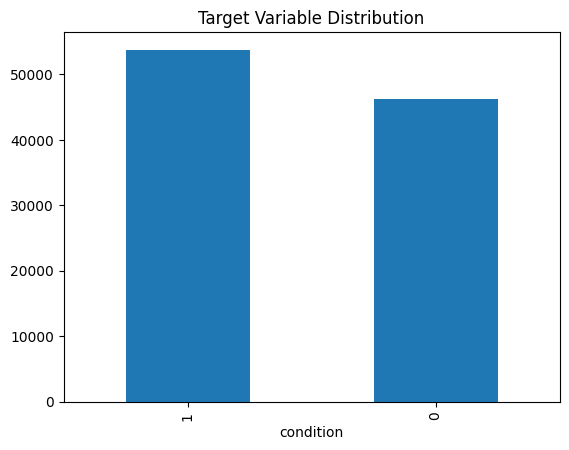

In [114]:
df_cleaned['condition'].value_counts().plot(kind='bar', title='Target Variable Distribution')
plt.show()

## Correlations

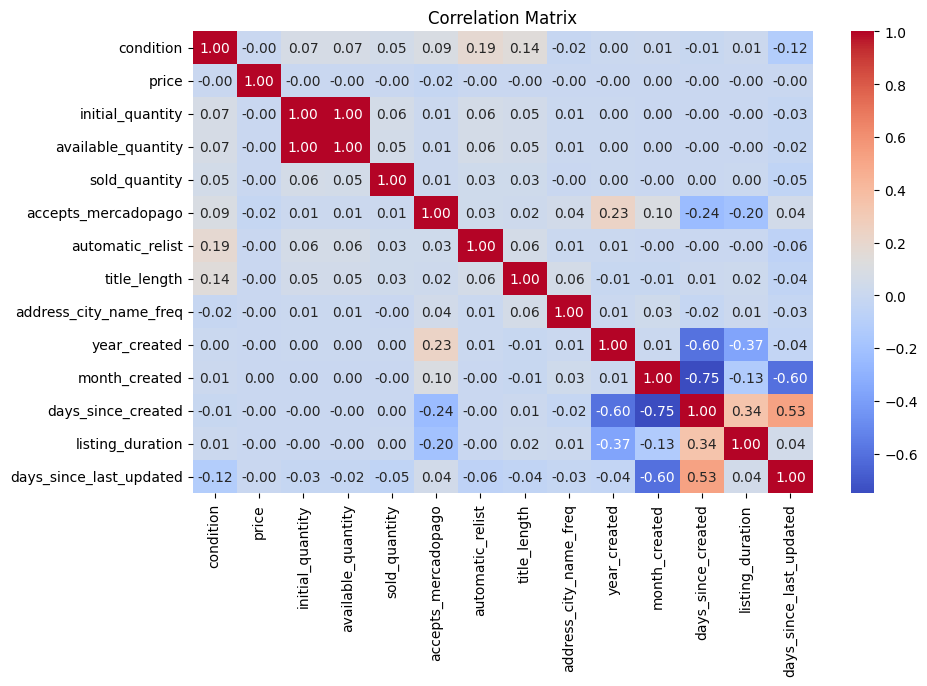

In [115]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_cleaned.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Since `initial_quantity` and `available_quantity` have a perfect correlation (correlation = 1), they contain the same information in different forms. In such cases, keeping both is redundant, so we should drop one. Dropping `initial_quantity` is usually better because `available_quantity` reflects real-time inventory changes that could relate to how items are sold over time.

In [120]:
df_cleaned.drop(["initial_quantity"], axis=1, inplace=True) 

## Distributions

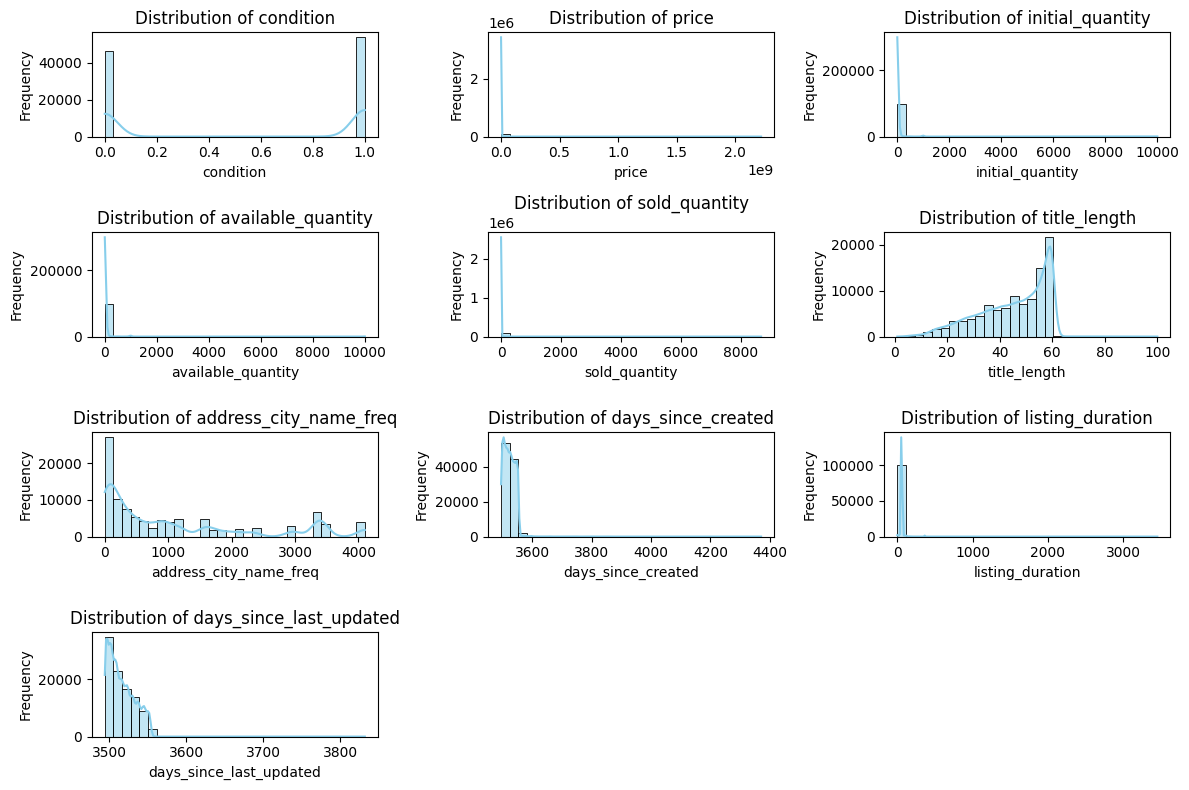

In [119]:
numeric_columns = df_cleaned.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(12, 8))

for i, column in enumerate(numeric_columns, 1):  
    plt.subplot(4, 3, i)  # Adjust rows and columns to fit all columns
    sns.histplot(df_cleaned[column], kde=True, bins=30, color='skyblue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [128]:
df_cleaned.to_csv('df_cleaned.csv', index=False)